# Progression of COVID-19 spread
> Some visuals using Open public API

- toc: false
- badges: true
- comments: true
- categories: [coswara,tutorial,covid]
- image: images/chart-preview.png
- author: Neeraj Sharma

# Linear Prediction.... What's that? 

## Correlations in a time-series

Consider you have a time-series data, discrete sampled from an underlying continuous-time signal such that, the data samples are uniformly spaced apart in time. An example is shown in the below figure.

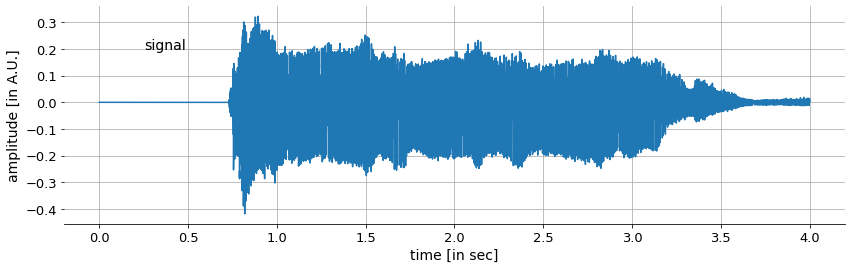

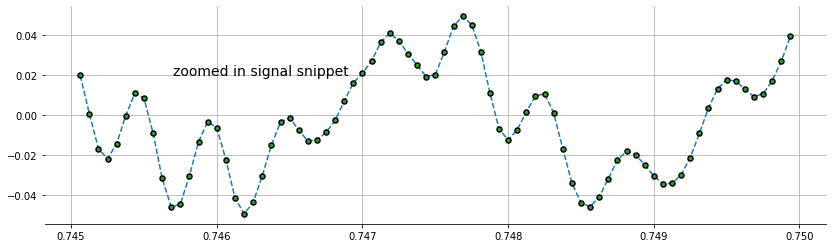

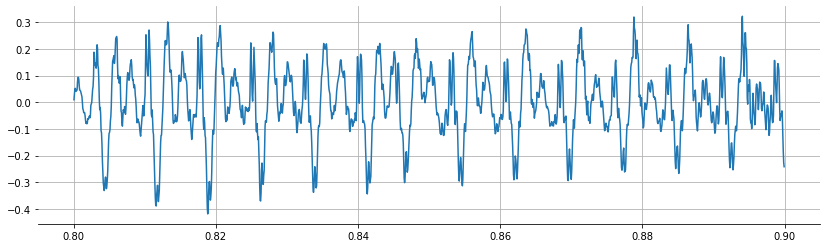

In [9]:
import numpy as np
import librosa 
import matplotlib.pyplot as plt
import pickle
from PyEMD import EMD
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import datetime
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


Let us try to understand if there is any correlation between sample at current time with the sample ay previous time step. We can visualize this correlation by plotting `x[n] vs x[n+1]`. The plot below depicts this, and it is clear that there exists a high correlation. We can remove this correlation using PCA but we don't want to do this. Instead we will exploit this correlation to obtain a linear model for the time-series data. Welcome to linear prediction modeling.

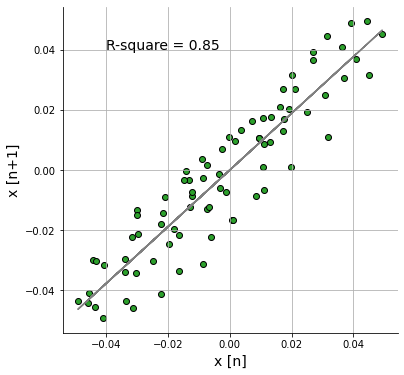

In [85]:
#collapse
X = signal[indx]
Y = signal[indx+1]
reg = LinearRegression(fit_intercept = False).fit(X.reshape(-1,1), Y)
reg.score(X.reshape(-1,1), Y)
Y_est = reg.coef_*X

fig = plt.subplots(figsize=[6,6])
ax = plt.subplot(1,1,1)
ax.grid(True)
ax.scatter(signal[indx],signal[indx+1],color='tab:green',edgecolor='black')
ax.plot(X,Y_est,'-',color='gray')
plt.ylabel('x [n+1]', fontsize=14)
plt.xlabel('x [n]', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.text(-.04,.04,'R-square = '+str(round(reg.score(X.reshape(-1,1), Y),2)),fontsize=14)
plt.show()

## Modeling a time-series

Given a time series, we can compute some simple statistics, or even obtain power spectral density. But how about being able to predict the next sample in the series? If the signal samples are uncorrelated then prediction is hopeless, but not otherwise. Interestingly, time-series data obtained in an experiment is not white. Infact, peaks in the Fourier spectrum of a time-series data indicates that there is correlation between samples. Lets establish a model for the signal based on the assumption that the current sample can be predicted from the past samples and current (and) past inputs.
$$ x[n] = \sum_{k=1}^P a_k x[n-k] + G\sum_{k=0}^Q b_ke[n-k],\ b_0=1 $$

where, `a_k` and `b_k` are scalars and referred to as the linear prediction coefficients.

* Does the above equation makes sense? Lets simplify. If we assume all `a_k`s are zero then we have a simple moving average (MA) model running on the input `e[n]`. If we assume all `b_k`s are zero we have an auto-regressive (AR) model. In this notebook we will focus on the AR model. Intuitively, this model says that the output `x[n]` is expressed as a linear function of past `P` output samples and the current input sample `e[n]`. This looks like a simple model, right? For instance, we could have introduced non-linearity but we did not. The advantage of this simple model is that we can minimize a cost function and estimate the `a_k`s. The estimation can get complicated if the signal model has non-linearity.

* Lets bring some more intution to what is `e[n]`. If `x[n]` is output from a system then `e[n]` models the input to the system. Alternatively, we can also interpret `e[n]` as the error signal which could not be modeled by the prediction using the past `P` output samples. That is, 

$$Ge[n] = x[n] - \sum_{k=1}^P a_k x[n-k]$$
Thus, we expect `e[n]` to be high in magnitude at time instants were our prediction using the past output samples is poor, and low otherwise.

* How do we estimate `a_k`s? First we need a cost function (E), and then we minimize this cost function over `a_k`s. The cost function of choice is mean square square (M.S.E). That is, 

$$E = \sum_ne[n]^2 = \sum_n\big(x[n]-\sum_{k=1}^P a_k x[n-k]\big)^2$$

* Some terminologies: `P` is referred to as the order of the AR model. How do we choose `P`? There is an answer but before going there we need to understand some more things.

* Once we `a_k` we have the signal model! But how does this help in ways other than predicting the next sample in the time series?

## Linear prediction  model as a time-series analysis tool

We can write the model in z-transform domain. Don't know z-transform? No worries, you can skip this part. Will you like to know about z-transform? Yes, then do see this [wiki](https://en.wikipedia.org/wiki/Z-transform#:~:text=In%20mathematics%20and%20signal%20processing,equivalent%20of%20the%20Laplace%20transform.). Continuing, below is our system model and its z-transform.
\begin{align}
x[n] = \sum_{k=1}^P a_k x[n-k] + Ge[n]\\
X[z] = \sum_{k=1}^P a_k z^{-k}X[z] + E[z]\\
X[z] = H[z] \times E[z]\\
H[z] = \dfrac{1}{1-\sum_{k=1}^P a_k z^{-k}}
\end{align}

Note that we are able to decompose (or "factorize") the spectrum of the time-series `x[n]` into a product of two different spectrums. That is, $X[z]=H[z]E[z]$. This is cool. Why? Suppose I ask you to factorize 96 into two numbers.
\begin{align}
96 &= 16*6\\
   &= 24*4\\
   &= \cdots
\end{align}
There are many possibilities. Can we ask the same question for a spectrum? Yes, and linear prediction offers us one such factorization. Okay, but what is its worth? To answer this we should visualize the `H[z]` and `E[z]` using some example time-series data. 

## Geting to code

Consider we have a time-series data, `x`, composed of `N` samples. Recalling the linear prediction signal model for `x` we have,
$$ x[n] = \sum_{k=1}^P a_k x[n-k] + e[n] $$

The goal of the code will be to estimate the prediction coefficients $\{a_1,\dots,a_P\}$

\begin{align}
\begin{bmatrix} 
    x_{n} \\
    x_{n+1}\\
    \vdots\\
    x_{n+N}
\end{bmatrix} =  
\begin{bmatrix} 
    x_{n-1} & x_{n-2} & \dots & x_{n-P} \\
    x_{n} & x_{n-1} & \dots & x_{n+1-P} \\
    \vdots & \ddots & \\
    x_{n+N-1} & x_{n+N-2} & \dots & x_{n+N-P} \\
    \end{bmatrix}
\begin{bmatrix} 
    a_{1} \\
    a_{2}\\
    \vdots\\
    a_{P}
\end{bmatrix}
\end{align}
    

In [4]:
#collapse
def autocorrelate(x,n):
    '''
    Computes normalized autocorrelations
    '''
    A = np.array([sum(x[0:len(x)-i:]*x[i:len(x):])/(len(x)) for i in range(n+1)])
    
    return A/float(A[0])

def levinsonDurbin(R):
    '''
    Implemments Levinson-Durbin's iterative approach to compute prediction coefficients
    Compute normalized autocorrelations
    '''
    
    nPoles = len(Rm)-1
    En = np.zeros(nPoles+1)
    Rc = np.zeros(nPoles)
    En[0] = Rm[0]
    Ak = np.array([-Rm[1]/Rm[0]])
    Rc[0] = Ak
    V = Rm[0]-pow(Rm[1],2)/Rm[0]
    En[1] = V
    n = 0
    while n < (nPoles-1):
        alfa = sum(np.append(1,Ak)*Rm[n+2:0:-1])
        rho=- alfa/V
        Rc[n+1] = rho
        V = V+rho*alfa
        En[n+2] = V
        Ak = np.append(Ak+rho*Ak[::-1],rho)
        n+= 1
    return np.append(np.concatenate(np.ones((1,)),np.array(Ak)))
        
def paper_levinsonDurbin(R):
    P = len(R)-1
    E = []
    E.append(R[0])
    k = []
    a_prev = np.zeros((P,))
    a = np.zeros((P,1)
    
    for i in range(1,P):
        alpha = R[i]
        for j in range(1,i-1):
            alpha+ = a_prev[j]*R[i-j]
        k.append(-alpha/E[i-1])
        a[i] = k[i]
        
        for j in range(1,i-1):
            a[j] = a_prev[j] + k[i]*a_prev[i-j]
        E.append((1-k[i]**2)*E[i-1])

    return np.append(np.concatenate(np.ones((1,)),a))
                 
def paper_levinsonDurbin(R):
    '''
    Levinson Durbin method. Implementation is based on the pseudo-code in:
    "" J. Makhoul, Linear Prediction: a tutorial, IEEEE, 1975.
    '''
    P = len(R)-1
    E = []
    E.append(R[0])
    k = [0]
    a = np.zeros((P+1,))
    a[0] = 1
    i = 1
    while i< (P+1):
        j = 1
        alpha = 0
        while j<i:
            alpha = alpha + a_prev[j]*R[i-j]
            j = j+1
        k.append((-R[i]-alpha)/E[i-1])
        E.append((1-k[i]**2)*E[i-1])
        a[i] = k[i]
        j = 1
        while j < i:
            a[j] = a_prev[j] + k[i]*a_prev[i-j]
            j = j+1
        a_prev = a.copy()
        i = i+1

    return a

def do_lpc(signal,lpOrder=20,windowSize=512,overlap=0):
    '''
    LPC main function
    '''
    windowShift = windowSize-int(windowSize*overlap)

    start_point = 0
    end_point = windowSize

    R = np.zeros(signal.shape) if overlap == 0 else None
    signal_memory = np.zeros((lpOrder,)) if overlap == 0 else None        
    
    F = []; A = [];
    
    while end_point < len(signal):
        signalFrame = signal[start_point:end_point]
        Rx = autocorrelate(signalFrame,lpOrder)
        Ak = levinsonDurbin(Rx)
        A.append(Ak)
        w,h = freqz(1,Ak.T,windowSize)
        F.append(np.log(np.abs(h)))
        s = np.concatenate((signal_memory,signalFrame))
        if overlap == 0:
            residual = np.convolve(s,Ak)        
            R[start_point:end_point]+= residual[lpOrder:-lpOrder]
            signal_memory = signalFrame[-lpOrder:]
            E = np.log(np.sum(R[start_point:end_point]**2)/windowSize)
            F[-1] = F[-1] + E       
        start_point+= windowShift
        end_point = start_point+windowSize
        
    return np.array(A).T,R,np.array(F).T,w

In [89]:
for i in range(1,0):
    print(i)

Load the signal using librosa.
The code below also converts the signal to 8 KHz sampling rate.

Text(0, 0.5, 'Frequency (KHz)')

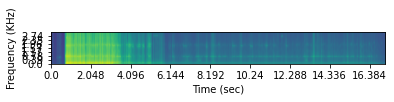

In [87]:
#collapse
signal,fs = librosa.load('./my_data/nMIOAh7qRFf3pqbchclOLKbPDOm1_heavy_cough.wav',sr=8000)

overlap = 0
windowSize=int(32e-3*fs)
windowShift=windowSize-int(windowSize*overlap)
lpOrder=12

Ak,Residual,FResp,FSamples=do_lpc(signal,lpOrder,windowSize=windowSize,overlap=overlap)

f = plt.figure()
ax=f.gca()
ax.imshow(FResp)
ax.set_aspect(.1)
plt.yticks([i for i in np.arange(0,len(FSamples),64)],[int(FSamples[i]*100)/100.0 for i in np.arange(0,len(FSamples),64)])
plt.xticks([i for i in np.arange(0,FResp.shape[1],64)],[i*windowShift/float(fs) for i in np.arange(0,FResp.shape[1],64)])
ax.invert_yaxis()
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (KHz)')
plt.show()

f = plt.figure()
ax=f.gca()
ax.plot([i/float(fs) for i in range(len(signal))],signal)
ax.plot([i/float(fs) for i in range(len(Residual))],Residual)
plt.xlim([0,len(Residual)/float(fs)])
#plt.xlim([3.2,3.25])
plt.xlabel('Time (sec)')
plt.xlim([.5,.55])
plt.ylim([-.1,.1])